# Individual Data Generation Example
For the individual data generation, the probability to have a true positive label is dependant on the previous predictions for the individual. The number of positive and negative predictions defines, how close an individual is to the decision boundary.

In [1]:
import sys
import numpy as np
sys.path.append("../")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from aif360.algorithms.inprocessing import PrejudiceRemover

from long_term_fairness.ltf_plot import LongTermFairnessPlot
from long_term_fairness.ltf_data.individual_data_generator import DataGenerator as IndDataGen
from long_term_fairness.ltf_aif.longterm_aif import AifLongTermMetric, AifLongTermPrediction

Import error: No module named 'tensorflow'


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
class CLF:
    def __init__(self, clf=LogisticRegression()):
        self.c = clf
    def predict(self, X, X_s):
        return self.c.predict(X)
    def fit(self, X, X_s, y):
        self.c.fit(X, y)   

## 1. Unconstrained Example
First, a unconstrained linear svm is trained. In the first generation, both baseline and true data are identical.
Because the svm is unconstrained, it perfectly distinguishes the data points. Hence, the number of positive and negative labels does not change with time. Contrary, in the baseline data (generated assuming all previous predictions of each individual were positive) all data points are considered positive.

In [4]:
generator = IndDataGen(mean_pos=[0, 1],
                       mean_neg=[8, 9],
                       num_positive_label=50,
                       num_negative_label=50,
                       discrimination_factor=.9)

In [5]:
metric = AifLongTermMetric()

In [6]:
clf = CLF(LinearSVC())

In [7]:
l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 12], y_lim=[-1, 13])

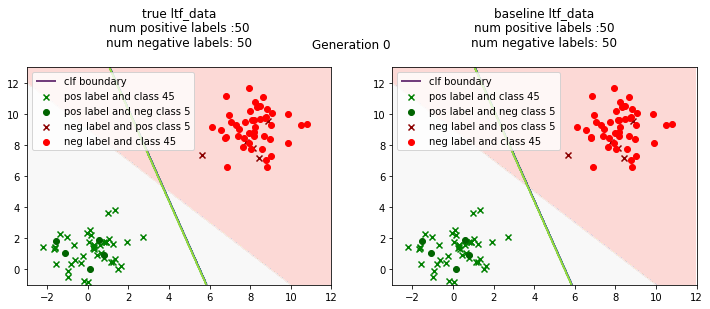

In [8]:
l.init_data()
l.plot_generation()

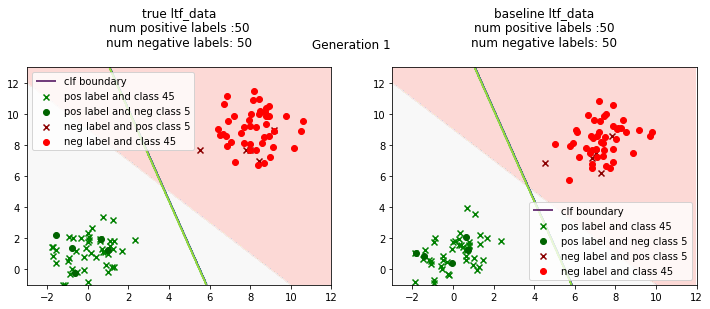

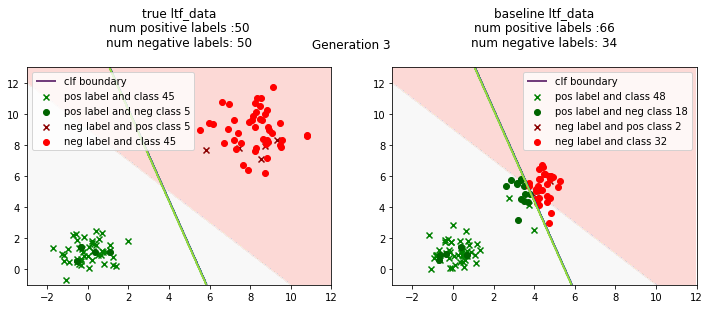

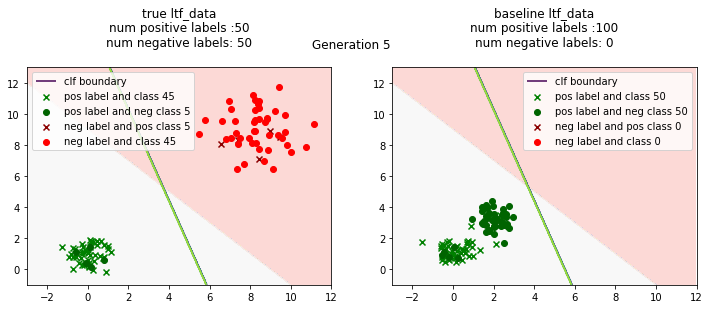

In [9]:
for i in range(6):
    l.run_generation()
    l.run_baseline_generation()
    if i % 2 == 0:
        l.plot_generation()

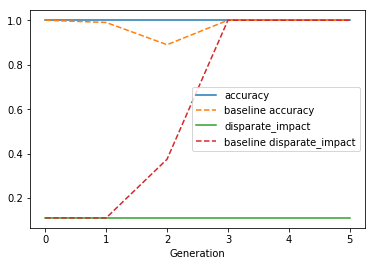

In [10]:
l.plot_ltf(metric._metrics)

From above plot it is visible, that accuracy and disparate impact are constant over time in the true case, while disparate impact improves in the baseline case. 

## For Completeness: Logistic Regression
Performing the same experiment with logistic regression another decision boundary is found, which is further away from the true data generating decision boundary. However, this does not really change the results here.

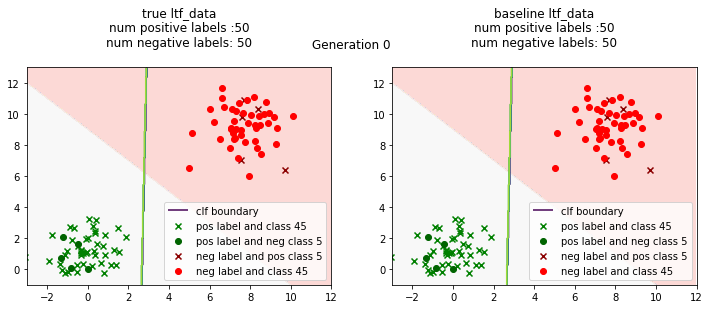

In [11]:
clf = CLF(LogisticRegression())
l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 12], y_lim=[-1, 13])

l.init_data()
l.plot_generation()

## 2. Constrained Example 
The constrained classifier learns another decision boundary and has to except errors to satisfy fairness. This example is done using an artificial rule.

In [12]:
class FairCLF:
    def predict(self, X, X_s):
        pred = [5, -12] @ X.T + 50
        
        pred[pred>0] = 1
        pred[pred<0] = 0
        
        return np.sign(pred)
    def fit(self, X, X_s, y):
        pass

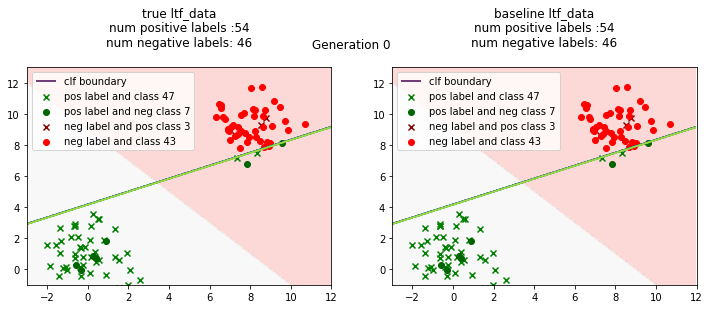

In [13]:
clf = FairCLF()

l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 12], y_lim=[-1, 13])

l.init_data()
l.plot_generation()

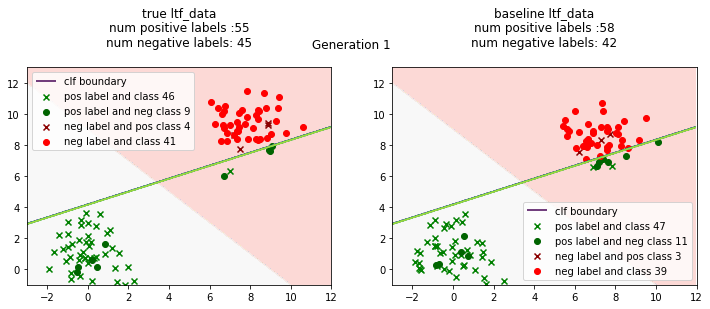

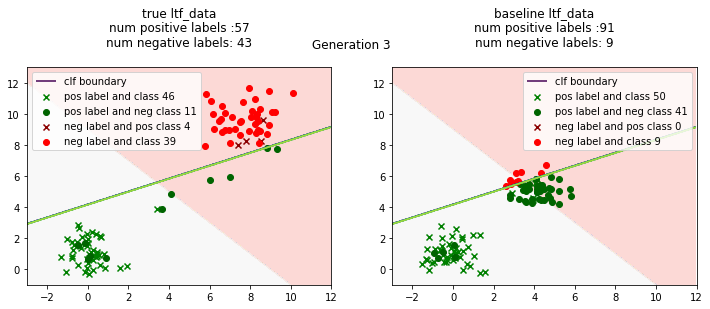

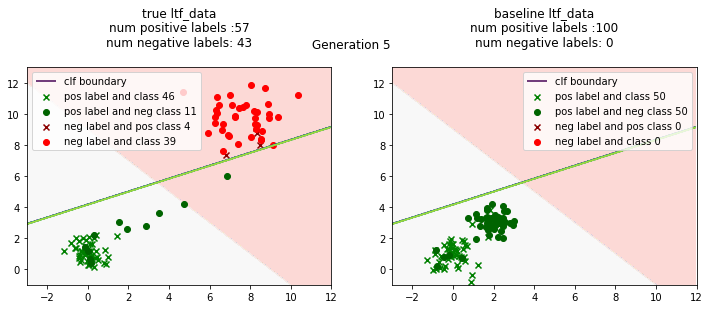

In [14]:
for i in range(6):
    l.run_generation()
    l.run_baseline_generation()
    if i % 2 == 0:
        l.plot_generation()

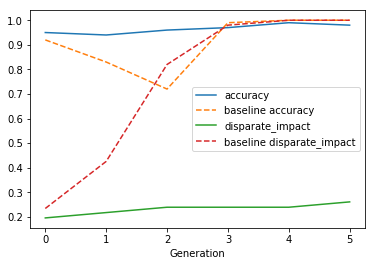

In [15]:
l.plot_ltf(metric._metrics)

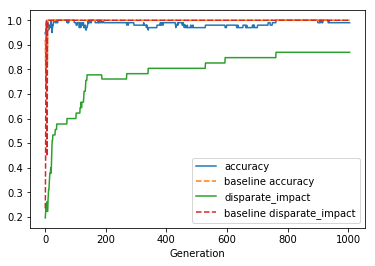

In [16]:
l.run(1000)
l.plot_ltf(metric._metrics)

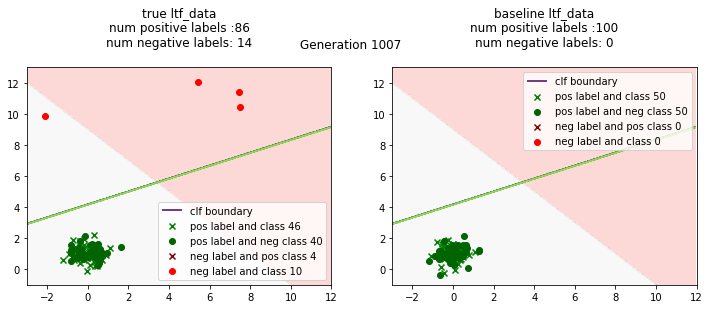

In [17]:
l.plot_generation()

Note that is this case the decision rule has a long term effect. Because of the position of the decision boundary each individual has a small chance to be assigned an positive label. Therefore, this decision rule will in long term lead to perfect fairness as described by the baseline data. However, even after 1000 generations this is not the case here. Furthermore, this does only work in this example, where most individuals are close to the decision boundary.

TODO: increase variance of clusters